In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# The MNIST Dataset
We'll start building our first neural network with the MNIST dataset. The MNIST dataset contains 70,000 labeled images of handwritten digits. The goal of our neural network is to train it to discern handwritten digits as accurately as possible.

In machine learning, you want to break your data into two sets: training data and testing data. Neural networks learn by consuming training data and adjust their network accordingly to more accurately detect the next piece of data. After you train your network, you'll want to assess its accuracy on data is has not seen before. This is where the test data comes handy. Rather than consuming and tuning, the network will simply consume test data and report its accuracy. This gives an idea of how it would perform under general circumstances.

Let's go ahead and load the MNIST dataset:

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


## Exploring The Data
Let's get a better idea of what the data looks like by printing out the shape of both the training and testing data:

In [3]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


The shape of the data tells us a few things. First, we can see that there are 60,000 training images and 10,000 testing images. We can gather that the images are 28 pixels wide by 28 pixels long and that `y_train` and `y_test` contain label data. Let's double check to make sure our assumptions are true.

Let's print out the first piece of data from `x_train` and see what we get:

In [4]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

If you take a glance at the data, you can see you have values ranging from 0 to about 250. We can take a pretty confident guess that this is 8-bit pixel data (with the max pixel value being $2^8-1 = 255$). We're going to assume that the test data is similar as well, but feel free to double-check for your own sanity's sake.

Now, let's print out the first piece of data from `y_train`:

In [5]:
print(y_train[0])

5


Hmm. `5` doesn't really give us much to go on, so let's instead print the minimum and maximum values of `y_train`:

In [6]:
print("Maximum value: ", max(y_train))
print("Minimum value: ", min(y_train))

Maximum value:  9
Minimum value:  0


It looks like we have 10 different labels, which makes sense because there's only 10 digits in our base-10 notation.

We played a little dumb in this section for the sake of exploration. We didn't have to do as much digging as we did and could instead have deduced most of this information by the shape of the dataset alone. But I always err on the side of double checking your assumptions.

For clarity, let's name our datasets something a little more verbose:

In [7]:
# Aliasing the test data
training_images = x_train
training_labels = y_train
test_images = x_test
test_labels = y_test

## Displaying The Data
This step isn't necessary in the machine learning pipeline. Our neural network doesn't need to "see" our data perse, but it definitely helps us understand our data a little better.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

After importing `matplotlib`, we can display the data. Let's do the first five training images:

Text(0.5, 1.0, 'training_images[4]')

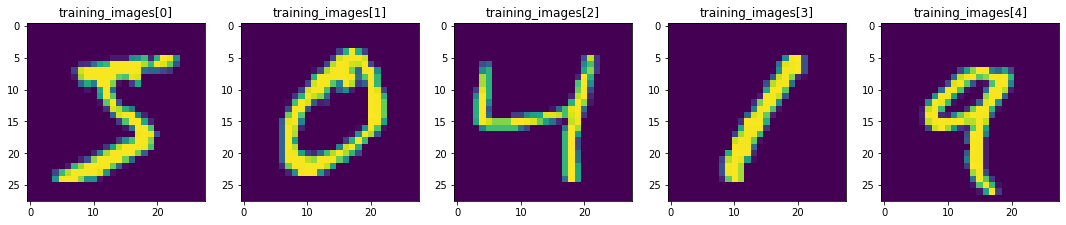

In [9]:
# Displaying first five images
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(18.5, 10.5)
axs[0].imshow(training_images[0, :, :])
axs[0].set_title("training_images[0]")
axs[1].imshow(training_images[1, :, :])
axs[1].set_title("training_images[1]")
axs[2].imshow(training_images[2, :, :])
axs[2].set_title("training_images[2]")
axs[3].imshow(training_images[3, :, :])
axs[3].set_title("training_images[3]")
axs[4].imshow(training_images[4, :, :])
axs[4].set_title("training_images[4]")

And we can see this matches up with the label data:

In [10]:
print(training_labels[:5])

[5 0 4 1 9]


## Data Prepping
Before we get into constructing and training the neural network, we need to prepare our data for consumption.

First we're going to reshape the image data by flattening it:

In [11]:
# Flattening the image data
training_images = tf.reshape(x_train, [-1, 28*28])
test_images = tf.reshape(x_test, [-1, 28*28])

Just to make sure, let's print out one of these images to make sure we reshaped them okay. They won't display because the pixel data is now in a single vector, but we can take just one image and reshape it back to its original 28x28 dimension:

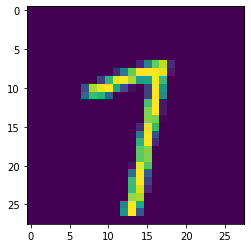

In [12]:
plt.imshow(tf.reshape(training_images[42], [28, 28]))

Looks pretty good to me. I'm assuming the `-1` in the `reshape` parameter is used to flatten whatever wasn't specified in the shape. For example, if we run `tf.reshape(x_train, [28, -1, 4])`, I'm expecting we will get a tensor shape of (28, 7\*60000, 4). Feel free to run it yourself to check.

We're not quite done yet. We still have to normalize the data to values between 0 and 1. Since our values are `uint8`, we're going to have to cast them as floats before normalizing them:

In [13]:
# Normalize image data
training_images = tf.dtypes.cast(training_images, tf.float32) / 255.0
test_images = tf.dtypes.cast(test_images, tf.float32) / 255.0

Now our data should be good to go 👍

# The Neural Network
Finally, we're going to construct the neural network. We're going to ignore a few minor implementation details, but after we have it running, it should be pretty intuitive what is going on.

Let's create the structure of the network:

In [14]:
# Constructing the model
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10),
])

Our network consists of three layers, including an output layer. The first layer has 512 nodes and the second has 256 nodes. The output layer has only 10 nodes which will denote the confidence values that a particular image is a certain digit.

Now, we're going to compile the model:

In [15]:
# Compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"],
)

Finally, we can train the network:

In [16]:
# Train the model
model.fit(training_images, training_labels, batch_size=32, epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 3s - loss: 0.1858 - accuracy: 0.9437
Epoch 2/5
1875/1875 - 2s - loss: 0.0796 - accuracy: 0.9752
Epoch 3/5
1875/1875 - 2s - loss: 0.0544 - accuracy: 0.9823
Epoch 4/5
1875/1875 - 2s - loss: 0.0410 - accuracy: 0.9872
Epoch 5/5
1875/1875 - 3s - loss: 0.0310 - accuracy: 0.9898


Our next step is to test how well our network performs on data it has never seen before. This is where our test set comes in handy:

In [17]:
# Evaluate model's performance
model.evaluate(test_images, test_labels, batch_size=32, verbose=2)

313/313 - 0s - loss: 0.0884 - accuracy: 0.9779


[0.08842284232378006, 0.9779000282287598]

Running the evaluation, you'll get roughly about a 97% to 98% accuracy, which is pretty good. Note that the accuracy during evaluation might be a little lower than the accuracy at the end of training. This makes sense because the network will slightly increase its fit to the training data after each training iteration, so the network will become more and more sensitive to any details that diverges from the training dataset. This is a phenomena known as _overfitting_.